<a href="https://colab.research.google.com/github/MahanandAdimulam/Image-Classifier/blob/master/sad_happy_people_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import tensorflow as tf
import os

In [3]:
#Avoid OOm errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#1. Preparing the data

##1.1 Removing Dodgy Images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = '/content/gdrive/MyDrive/Image Classifier/data'
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("issue with image {}".format((image_path)))

##1.2 Loading the dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
data = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/Image Classifier/data', batch_size=8)

Found 157 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
#Images represented as numpy arrays
batch[0].shape

(8, 256, 256, 3)

In [12]:
#Image labels
batch[1]

array([0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

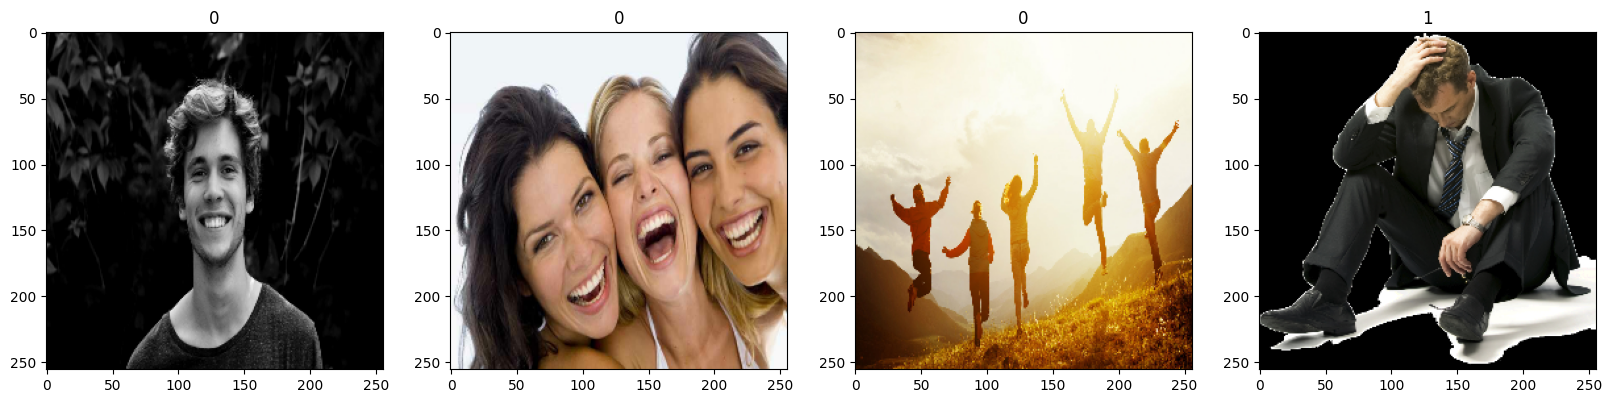

In [13]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#2. Preprocess the data

##2.1 Scale the data

In [14]:
data = data.map(lambda x,y :(x/255,y))

In [15]:
scaled_iterator = data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

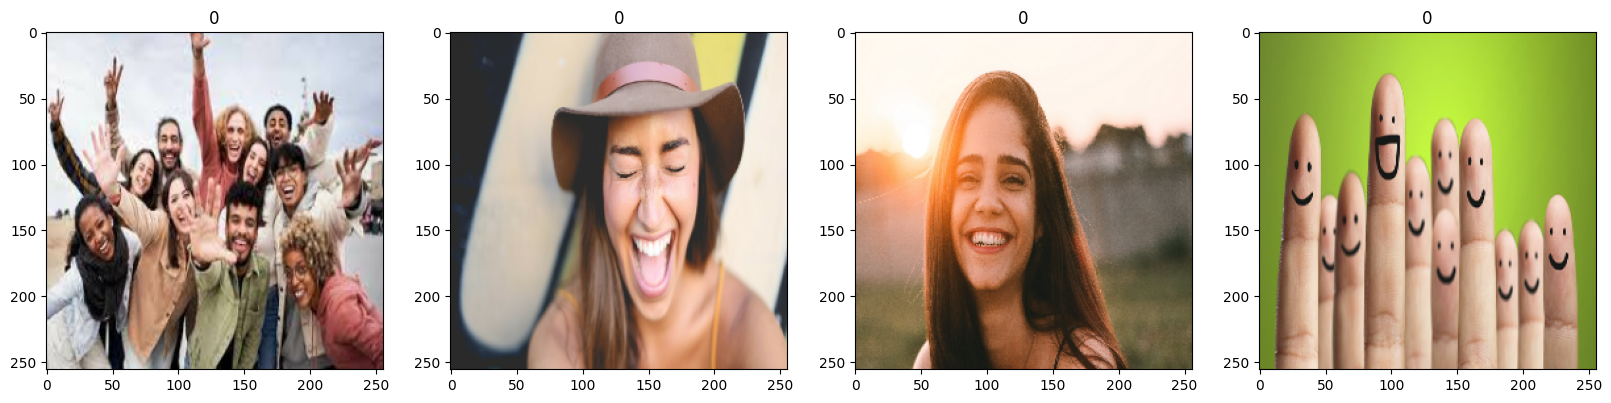

In [17]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

##2.2 Split the data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

#3. Deep Learning Model

##3.1 Build the deep learning model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

##3.2 Train the model

In [24]:
logdir='/content/logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
14/14 [==============================] - 9s 228ms/step - loss: 0.8882 - accuracy: 0.5625 - val_loss: 0.6728 - val_accuracy: 0.7500
Epoch 2/20
14/14 [==============================] - 5s 347ms/step - loss: 0.5510 - accuracy: 0.7500 - val_loss: 0.6433 - val_accuracy: 0.6562
Epoch 3/20
14/14 [==============================] - 4s 240ms/step - loss: 0.4355 - accuracy: 0.8214 - val_loss: 0.3332 - val_accuracy: 0.8125
Epoch 4/20
14/14 [==============================] - 4s 236ms/step - loss: 0.3284 - accuracy: 0.8929 - val_loss: 0.1597 - val_accuracy: 0.9688
Epoch 5/20
14/14 [==============================] - 5s 338ms/step - loss: 0.2093 - accuracy: 0.9196 - val_loss: 0.2003 - val_accuracy: 0.9688
Epoch 6/20
14/14 [==============================] - 4s 272ms/step - loss: 0.1966 - accuracy: 0.9196 - val_loss: 0.1192 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 5s 274ms/step - loss: 0.1338 - accuracy: 0.9643 - val_loss: 0.0952 - val_accuracy: 0.9375
Epoch 

##3.3 Performance Plot

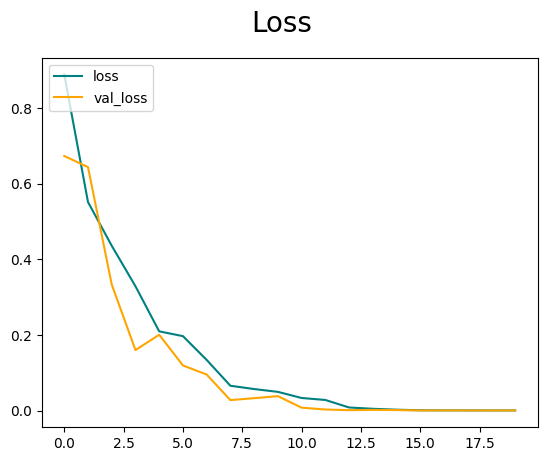

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

loss down and val_loss up then the model is over fitting

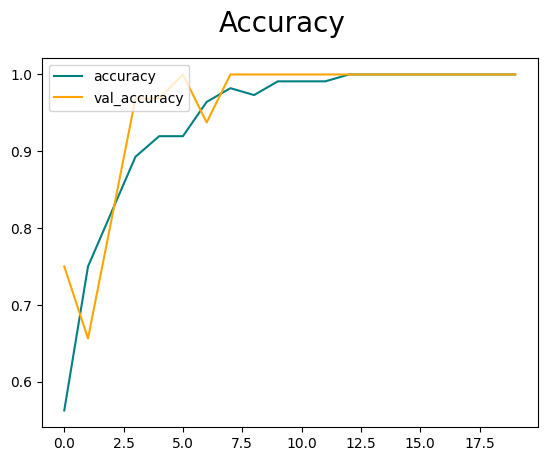

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#4. Evaluate the performance

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 243ms/step


In [32]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


#5. Test on new data

##5.1 Test for happy class

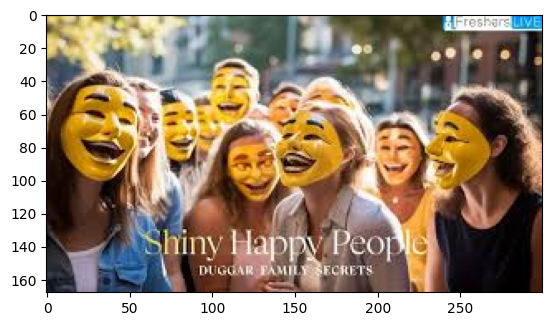

In [33]:
img = cv2.imread('/content/test_happy.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

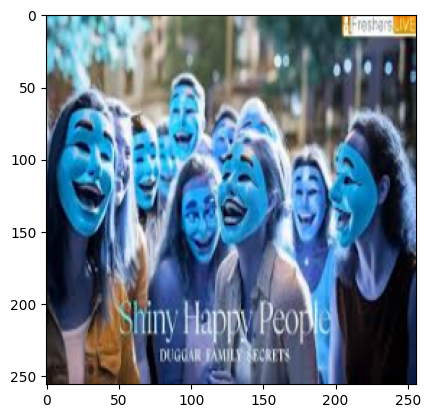

In [34]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [35]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 146ms/step


In [36]:
yhat

array([[0.52708685]], dtype=float32)

In [37]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


##5.2 Test for sad class

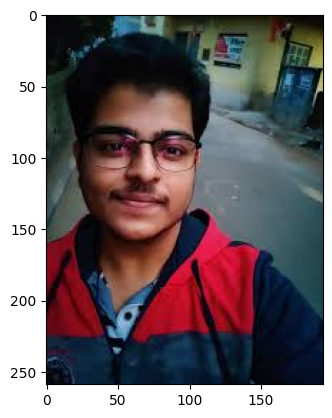

In [38]:
img2 = cv2.imread('/content/test_sad.jpeg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

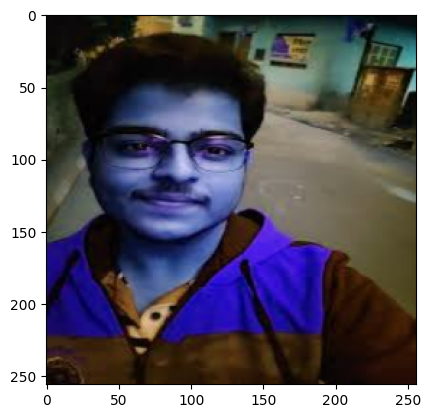

In [39]:
resize = tf.image.resize(img2, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [40]:
yhat1 = model.predict(np.expand_dims(resize/255, 0))
yhat1

1/1 [==============================] - 0s 18ms/step


array([[0.99987376]], dtype=float32)

In [41]:
if yhat1 > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


#6. Save the model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model.save('happysadmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
